# Parkinson's Disease Progression Prediction with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the AMP®-Parkinson's Disease Progression Prediction dataset made available for this competition. The model must predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease. 

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

This notebook will also show how to do some pre-processing of the data to make it easier for an ML models to learn from it.

You'll also learn how to implement and use the evaluation metric used on this competition: SMAPE.

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the Required Libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow v" + tf.__version__)

TensorFlow Decision Forests v1.2.0
TensorFlow v2.11.0


# Load the Dataset

First, let us load the dataset using Pandas.

In [3]:
# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

We will now examine each of these DataFrames in detail.

UPDRS is a rating instrument used to measure the the severity and progression of Parkinson’s disease in patients.
When a patient visits the clinic, the clinic will record how the patient scored on 4 parts of  UPDRS test. This data can be found in `train_clinical`. The ratings for the the first 4 segments of UPDRS are available as `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4` in `train_clinical`.
Our goal is to train a model to predict these UPDRS ratings.

Let us examine the shape of `train_clinical` DataFrame.

In [4]:
print('clinical dataset shape:  ', train_clinical.shape)

clinical dataset shape:   (2615, 8)


The `train_clinical` data is composed of ***8* columns** and ***2615* entries**.  We can see all 8 dimensions of our dataset by printing out the first 5 entries using the following code:

In [5]:
# Display the first 5 examples
train_clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [6]:
print(len(train_clinical.groupby(['patient_id'])))
for i in train_clinical.groupby(['patient_id']):
    print(i[0],(i[1]))

248
55    visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0      55_0          55            0     10.0      6.0     15.0      NaN   
1      55_3          55            3     10.0      7.0     25.0      NaN   
2      55_6          55            6      8.0     10.0     34.0      NaN   
3      55_9          55            9      8.0      9.0     30.0      0.0   
4     55_12          55           12     10.0     10.0     41.0      0.0   
5     55_18          55           18      7.0     13.0     38.0      0.0   
6     55_24          55           24     16.0      9.0     49.0      0.0   
7     55_30          55           30     14.0     13.0     49.0      0.0   
8     55_36          55           36     17.0     18.0     51.0      0.0   
9     55_42          55           42     12.0     20.0     41.0      0.0   
10    55_48          55           48     17.0     16.0     52.0      0.0   
11    55_54          55           54     12.0     18.0     51.0      0.0   
12   

/tmp/ipykernel_34/302222693.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i in train_clinical.groupby(['patient_id']):


     visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
473   13618_0       13618            0     12.0     20.0     36.0      NaN   
474   13618_3       13618            3     12.0     22.0     45.0      NaN   
475   13618_6       13618            6     12.0     27.0     52.0      NaN   
476   13618_9       13618            9     12.0     22.0     40.0      6.0   
477  13618_12       13618           12     12.0     19.0     39.0      3.0   
478  13618_18       13618           18     10.0     20.0     34.0      6.0   
479  13618_24       13618           24     17.0     20.0     59.0      7.0   
480  13618_30       13618           30     15.0     21.0     48.0      5.0   
481  13618_36       13618           36      9.0     20.0     40.0      6.0   
482  13618_42       13618           42     10.0     19.0     33.0      5.0   
483  13618_48       13618           48      9.0     19.0     44.0      4.0   
484  13618_54       13618           54     12.0     24.0     45.

The clinic will also record the patient's **NPX**(Normalized Protein eXpression) value for all the proteins relevant to Parkinson's disease during each visit. **NPX** is nothing but the value representing the protein concentration in shells. This data is available in the `train_proteins` DataFrame.

Let us examine the shape of `train_proteins` DataFrame.

In [7]:
print('proteins dataset shape:  ', train_proteins.shape)

proteins dataset shape:   (232741, 5)


The `train_proteins` data is composed of ***5* columns** and ***232741* entries**. We can see all 5 dimensions of our dataset by printing out the first 5 entries using the following code:

In [8]:
# Display the first 5 examples
train_proteins.head(5)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


Proteins are long molecules made up of multiple peptides. The clinic will record the **Peptide Abundance** of each peptide in proteins relevant to Parkinson's disease. It shows the peptide concentration, similar to NPX for proteins.  This data can be found in the `train_peptides` DataFrame.

Let us examine the shape of the `train_peptides` DataFrame.

In [9]:
print('peptides dataset shape:  ', train_peptides.shape)

peptides dataset shape:   (981834, 6)


The **train_peptides** data is composed of ***6* columns** and ***981834* entries**. We can see all 6 dimensions of our dataset by printing out the first 5 entries using the following code:

In [10]:
# Display the first 5 examples
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


# Plotting clinical data

We will pick a random `patient_id` and plot the target label values(`updrs_1`, `updrs_2`, `updrs_3`, `updrs_4`) of the patient against each month(`visit_month`).

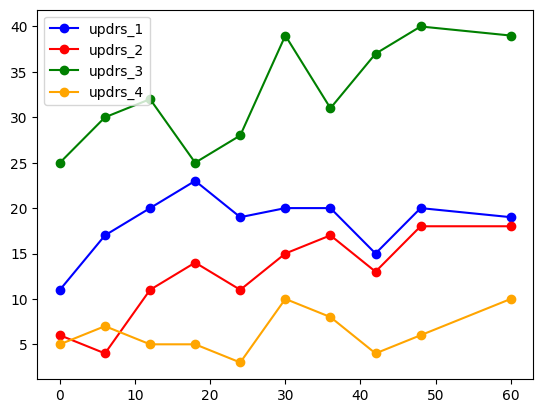

In [11]:
# Fetch data for patient with id 1517
plot_df = train_clinical[train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

# Plotting protein data


We will pick a random `patient_id` and plot the first 40 Protein entries(`UniProt`) of the patient and their NPX value against patient's visit month(`visit_month`).

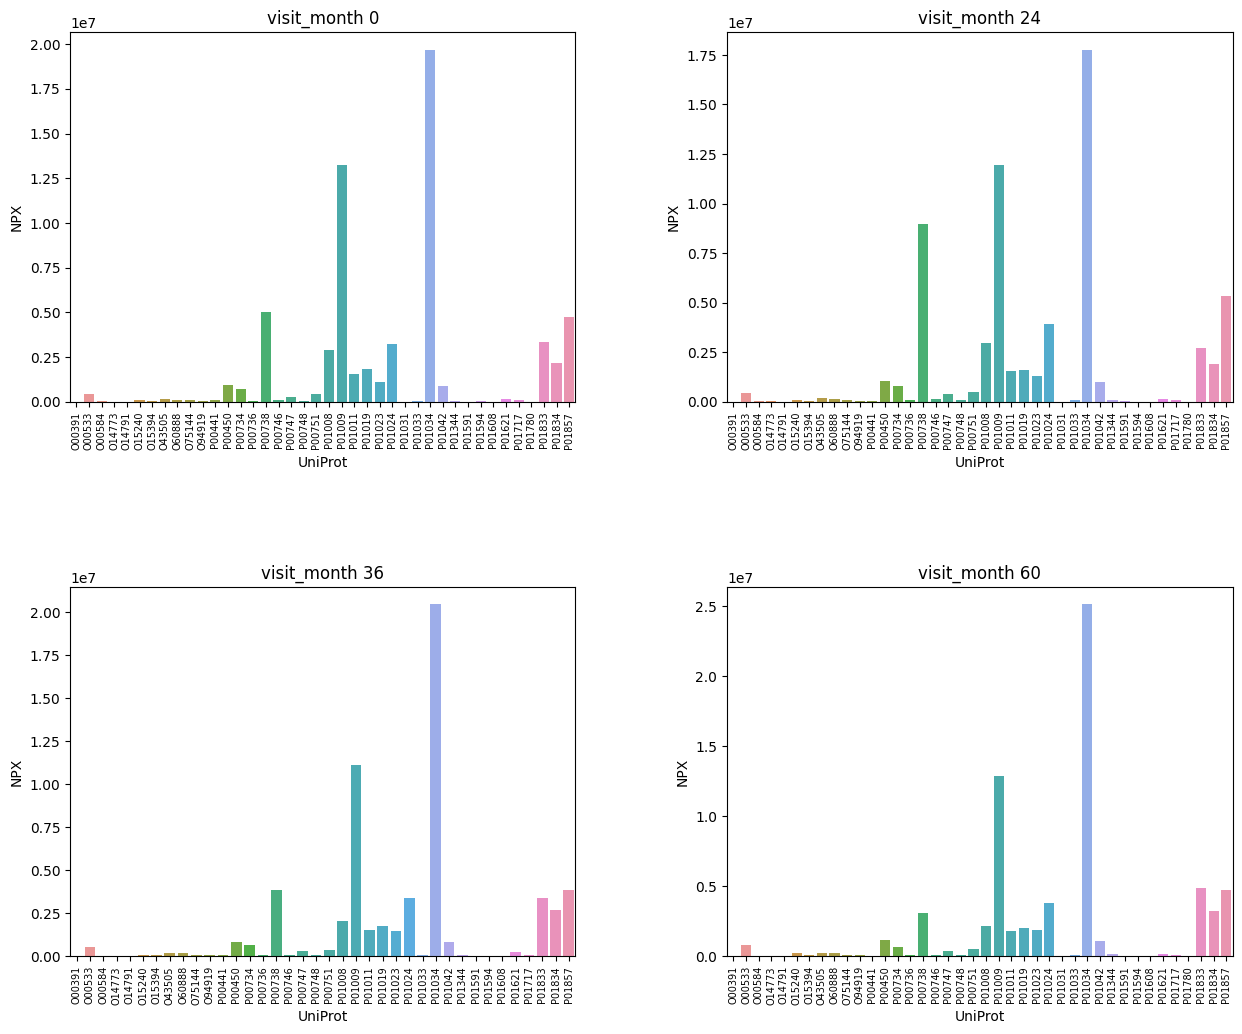

In [12]:
pro_plot_df = train_proteins[train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

# Prepare the dataset

We have to predict the ratings for the the first 4 segments of UPDRS `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4` that is likely to be recorded by the clinic during a patient visit. Hence these are our labels.

We will now prepare the dataset for training models to predict the 4 labels.

To predict the target labels(`updrs_1`, `updrs_2`, `updrs_3`, `updrs_4`) for a given visit, we will use the recorded protein and peptide data of the patient during that visit.

First we will group the rows in `train_proteins` data by visit ids (`visit id`) and protein ids (`UniProt`). Then we will replace the`NPX` values of each row in a group with the mean of the `NPX` values of all rows in that group.

Similarly we will group the rows in `train_peptides` data by their visit ids(`visit_id`) and peptide ids(`Peptide`). Then we will replace the `PeptideAbundance` values of each row in a group with the mean of the `PeptideAbundance` values of all rows in that group. 

Following figure shows the working of Pandas groupby function.

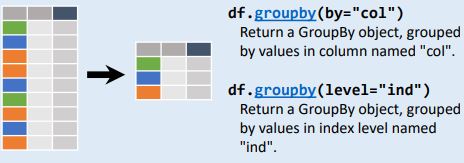

This image was taken from [https://pandas.pydata.org](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

Now we will spread the rows of the grouped datasets into columns. For this we will use the Pandas pivot function.

Below is a simple explanation for how the pivoting works.

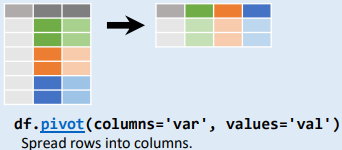

This image was taken from [https://pandas.pydata.org](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

The Protein dataset is pivoted such that unique values of `visit_id` become the indices and the values of `UniProt1` in the dataset become columns. For each visit(row), the `NPX` values corresponding to the different`UniProt1` values recorded for that visit are captured in the columns.

The Peptipe dataset is pivoted such that unique values of `visit_id` become the indices and the values of `Peptide` in the dataset become columns. For each visit(row), the `PeptideAbundance` values corresponding to the different`Peptide` values recorded for that visit are captured in the columns.

We will now merge the pivoted peptide dataset with the pivoted protein dataset on `visit_id`.

The figure shown below illustrates the logic behind Pandas merge function.

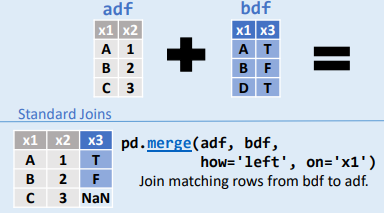

This image was taken from [https://pandas.pydata.org](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

In this notebook, we will let TensorFlow Decision Forests handle the missing values in the numerical columns.

In [13]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df
    

In [14]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

# Basic exploration of the prepared dataset

In [15]:
pro_pep_df.shape

(1113, 1196)

Our feature engineered dataset is composed of 1196 columns and 1113 entries.

Let us print out the first 5 entries using the following code:

In [16]:
# Display the first 5 examples
pro_pep_df.head(5)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [17]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


Now let us write a function to split the dataset into train and test datasets. This will be used in the training loop.

In [18]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

# Select a Model
There are several tree-based models for you to choose from.

- RandomForestModel
- GradientBoostedTreesModel
- CartModel
- DistributedGradientBoostedTreesModel

We can list all the available models in TensorFlow Decision Forests using the following code:

In [19]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

To get started, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

# How can I configure a tree-based model?

TensorFlow Decision Forests provides good defaults for you (e.g., the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

Before training the model, let us write a function to calculate the scoring metric of the competition.

# sMAPE

The scoring metric for this competition is sMAPE(symmetric Mean Absolute Percentage Error). In MAPE(Mean Absolute Percentage Error) we calculate the sum of absolute value of the forecast errors, divided by the actual values for each period([source](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)). 

Difference between MAPE and sMAPE is that sMAPE has both a lower bound and an upper bound. 


You can read more about sMAPE [here](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error).

Since TensorFlow Datasets doesn't have a bultin function to calculate sMAPE metric yet, we will write a custom function to calculate sMAPE.

In [20]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Training

We will train a model each to predict the first 4 segments of the UPDRS, `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4`. Thus we we will be training 4 models, one for each label.

We need to provide a few data structures to our training loop to store the trained models, sMAPE scores and mse scores for the trained models.

We will create these using the following code:

In [21]:
# Create an empty dictionary to store the models trained for each label.
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

Next, we will create a feature list with names of the columns we will use for training the model. We will avoid the column `visit_id` and add column the `visit_month`

In [22]:
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")

Now let us train the models.

In [46]:
# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

def func(row,grps,label):
#     print(type(row['visit_month']))
#     print(row[['visit_id','visit_month']])
#     print(0 in [int(i) for i in grps['visit_month']])
#     print(6 in [int(i) for i in grps['visit_month']])
#     print(24 in [int(i) for i in grps['visit_month']])
    #print(row[['visit_month','patient_id',label]])
    
    if int(row['visit_month']+6) in [int(i) for i in grps['visit_month']]:
#         print('YES 6')
#         print(row[['visit_month','patient_id',label]])
        row[label+'_6'] = grps.loc[grps['visit_month'].astype(int)==int(row['visit_month']+6)][label]
    
    if int(row['visit_month']+12) in [int(i) for i in grps['visit_month']]:
#         print('YES 12')
#         print(row[['visit_month','patient_id',label]])
        row[label+'_12'] = grps.loc[grps['visit_month'].astype(int)==int(row['visit_month']+12)][label]
                                   
    if int(row['visit_month']+24) in [int(i) for i in grps['visit_month']]:
#         print('YES 24')
#         print(row[['visit_month','patient_id',label]])
        row[label+'_24'] = grps.loc[grps['visit_month'].astype(int)==int(row['visit_month']+24)][label]
#     print(row[['visit_id',label+'_6',label+'_12',label+'_24']])

    return row

# Loop through each label   
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on = ['visit_id'], how = 'left')
    
    #print(dataset_df.head())
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    print(len(dataset_df))
    dataset_df[label+'_6'] = -1
    dataset_df[label+'_12']= -1
    dataset_df[label+'_24']= -1
    
    grps = dataset_df.groupby(['patient_id'])
    print(grps)
    grp1s = []
    for grp in grps:
#         print(grp)
        grp1 =grp[1]
#         print(type(grp1))
        grp1 = grp1.apply(lambda x: func(x,grp1,label),axis=1)
        grp1s.append(grp1)
#         print(grp)
    print(len(grp1s))
    #TODO - Data is in grps have to combine and seperate into mon6,12 and 24
    new_df = pd.concat(grp1s)
#     print(new_df.head())
    immediate = new_df.copy()
    mon6 = new_df.copy()
    mon12 = new_df.copy()
    mon24 = new_df.copy()
#     print(list(mon6['updrs_1_6'])[0])
    if label == 'updrs_1':
        mon6 = mon6[mon6['updrs_1_6'].astype(int)!= -1]
        mon12 = mon12[mon12['updrs_1_12'].astype(int) != -1]
        mon24 = mon24[mon24['updrs_1_24'].astype(int) != -1]
    if label == 'updrs_2':
        mon6 = mon6[mon6['updrs_2_6'].astype(int)!= -1]
        mon12 = mon12[mon12['updrs_2_12'].astype(int) != -1]
        mon24 = mon24[mon24['updrs_2_24'].astype(int) != -1]
    if label == 'updrs_3':
        mon6 = mon6[mon6['updrs_3_6'].astype(int)!= -1]
        mon12 = mon12[mon12['updrs_3_12'].astype(int) != -1]
        mon24 = mon24[mon24['updrs_3_24'].astype(int) != -1]
    if label == 'updrs_4':
        mon6 = mon6[mon6['updrs_4_6'].astype(int)!= -1]
        mon12 = mon12[mon12['updrs_4_12'].astype(int) != -1]
        mon24 = mon24[mon24['updrs_4_24'].astype(int) != -1]
#         print(mon6)
#     print(type(new_df['updrs_1_6'][0]))
    print(len(immediate),len(mon6),len(mon12),len(mon24))
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    
    
    
    c=0
    for dataset in [immediate,mon6,mon12,mon24]:
        s = ''
        if c==0:
            s = ''
        elif c==1:
            s = '_6'
        elif c==2:
            s = '_12'
        else:
            s = '_24'
         
        dataset = dataset.dropna(subset=[label+s])
        feature_list = FEATURES.copy() 
        feature_list.append(label+s)
        dataset[label+s] = dataset[label+s].astype('float')
        print(type(dataset[label+s].iloc[0]))
        print((dataset[label+s].value_counts()))
        # Split the dataset into train and validation datasets.
        train_df, valid_df = split_dataset(dataset[feature_list].drop(columns=['visit_month']))
        print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))

        # There's one more step required before we can train the model. 
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library 
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        print(label+s)
        
        
        
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=(label+s), task = tfdf.keras.Task.REGRESSION)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=(label+s), task = tfdf.keras.Task.REGRESSION)

        # We will now create the Random Forest Tree Model with default settings. 
        # By default the model is set to train for a classification task. Since this is a regression problem,
        # we will specify the type of the task (tfdf.keras.Task.REGRESSION) as a parameter here.
        rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, verbose=0)
        rf.compile(metrics=["mse"])

        # Train the model.
        rf.fit(x=train_ds)

        # Store the model
        model_dict[label+s] = rf

        # Evaluate the trained model on the validation dataset and store the 
        # mse value in the `mse_dict`.
        inspector = rf.make_inspector()
        inspector.evaluation()
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        mse_dict[label+s] = evaluation["mse"]  

        # Use the trained model to make predictions on the validation dataset.
        # Using these predictions, calculate and store the sMAPE value for this model.
        preds = rf.predict(valid_ds)
        smape_dict[label+s] = smape(valid_df[label+s].values.tolist(), preds.flatten())
        c +=1

1068


/tmp/ipykernel_34/3621051385.py:49: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for grp in grps:


248
1068 137 543 435
<class 'numpy.float64'>
1.0     118
2.0     107
5.0      90
6.0      88
4.0      79
3.0      79
7.0      67
8.0      64
0.0      62
9.0      58
10.0     42
11.0     42
12.0     32
14.0     24
13.0     21
16.0     17
15.0     15
20.0     13
17.0     12
18.0     11
19.0      9
25.0      5
21.0      3
26.0      2
22.0      2
23.0      2
28.0      1
24.0      1
27.0      1
33.0      1
Name: updrs_1, dtype: int64
853 examples in training, 215 examples in testing.
updrs_1


[INFO 2023-05-24T02:04:28.431773144+00:00 kernel.cc:1214] Loading model from path /tmp/tmpb3_4f622/model/ with prefix 98fcc1ee0471488e
[INFO 2023-05-24T02:04:28.699369146+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 72156 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:04:28.699574732+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:04:28.700422185+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
6.0     17
5.0     14
1.0     12
7.0     11
4.0     11
2.0      9
8.0      8
0.0      8
10.0     8
9.0      8
11.0     7
3.0      6
12.0     5
14.0     3
13.0     3
18.0     2
17.0     2
15.0     1
16.0     1
33.0     1
Name: updrs_1_6, dtype: int64
108 examples in training, 29 examples in testing.
updrs_1_6


[INFO 2023-05-24T02:05:04.728982983+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxqw8l6ff/model/ with prefix 108c340b2dc24620
[INFO 2023-05-24T02:05:04.770500019+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 10020 node(s), and 1153 input feature(s).
[INFO 2023-05-24T02:05:04.770826475+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:05:04.771644194+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
1.0     56
5.0     45
2.0     43
4.0     42
7.0     38
8.0     38
3.0     37
6.0     37
0.0     36
9.0     30
11.0    26
10.0    22
12.0    17
13.0    12
20.0    11
14.0    11
16.0    11
15.0     9
19.0     5
18.0     5
17.0     3
25.0     2
21.0     2
23.0     1
27.0     1
28.0     1
24.0     1
22.0     1
Name: updrs_1_12, dtype: int64
434 examples in training, 109 examples in testing.
updrs_1_12


[INFO 2023-05-24T02:05:51.241785569+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6wm_sxo2/model/ with prefix 194e7573d40d4352
[INFO 2023-05-24T02:05:51.391421726+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 39460 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:05:51.391731677+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:05:51.392566712+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
1.0     45
2.0     38
6.0     36
5.0     35
4.0     34
7.0     32
3.0     30
8.0     27
0.0     23
9.0     23
10.0    15
11.0    13
14.0    12
13.0    11
12.0    10
15.0    10
16.0     9
19.0     8
17.0     6
20.0     5
18.0     4
21.0     3
23.0     1
27.0     1
22.0     1
24.0     1
25.0     1
26.0     1
Name: updrs_1_24, dtype: int64
348 examples in training, 87 examples in testing.
updrs_1_24


[INFO 2023-05-24T02:06:32.603904508+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8fofzqgb/model/ with prefix 789f91f0a7af4db5
[INFO 2023-05-24T02:06:32.728605758+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 32086 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:06:32.728996137+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:06:32.729747274+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
1068


/tmp/ipykernel_34/3621051385.py:49: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for grp in grps:


248
1068 137 543 435
<class 'numpy.float64'>
0.0     263
2.0      85
3.0      76
8.0      65
5.0      64
1.0      63
4.0      62
7.0      55
6.0      50
9.0      39
10.0     38
13.0     29
15.0     29
11.0     28
14.0     23
12.0     22
16.0     12
18.0     12
20.0      9
17.0      8
19.0      7
22.0      6
21.0      6
23.0      5
26.0      3
24.0      3
27.0      3
28.0      2
29.0      1
Name: updrs_2, dtype: int64
874 examples in training, 194 examples in testing.
updrs_2


[INFO 2023-05-24T02:07:56.111629062+00:00 kernel.cc:1214] Loading model from path /tmp/tmplujb7oo6/model/ with prefix e9eb0789e1244a37
[INFO 2023-05-24T02:07:56.368831547+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 68304 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:07:56.369035271+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:07:56.370041095+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
2.0     15
7.0     15
8.0     13
3.0     11
9.0     11
4.0      9
5.0      9
10.0     8
1.0      7
6.0      6
14.0     6
20.0     4
13.0     4
0.0      3
11.0     3
12.0     3
19.0     2
15.0     1
27.0     1
16.0     1
28.0     1
23.0     1
22.0     1
21.0     1
24.0     1
Name: updrs_2_6, dtype: int64
110 examples in training, 27 examples in testing.
updrs_2_6


[INFO 2023-05-24T02:08:31.766512421+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbz3zgpe5/model/ with prefix 85e266d50e7a4cf8
[INFO 2023-05-24T02:08:31.809021521+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 10156 node(s), and 1135 input feature(s).
[INFO 2023-05-24T02:08:31.809323905+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:08:31.810121965+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0     141
3.0      41
8.0      36
2.0      35
4.0      35
5.0      32
7.0      26
9.0      24
1.0      24
10.0     23
6.0      22
13.0     16
15.0     16
14.0     13
12.0     11
11.0     10
16.0      7
18.0      6
17.0      5
19.0      4
23.0      3
22.0      3
20.0      3
26.0      2
21.0      2
24.0      1
28.0      1
27.0      1
Name: updrs_2_12, dtype: int64
429 examples in training, 114 examples in testing.
updrs_2_12


[INFO 2023-05-24T02:09:13.482406562+00:00 kernel.cc:1214] Loading model from path /tmp/tmpeacewlnj/model/ with prefix 2ae78c5d6a8a401d
[INFO 2023-05-24T02:09:13.6155788+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 35212 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:09:13.615903172+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:09:13.616684998+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0     107
5.0      31
8.0      29
1.0      28
3.0      27
4.0      26
2.0      25
6.0      21
7.0      20
9.0      16
11.0     13
10.0     13
14.0     11
12.0     11
13.0     10
15.0     10
16.0      7
18.0      7
17.0      4
21.0      3
23.0      3
19.0      3
20.0      3
26.0      2
22.0      2
24.0      1
27.0      1
29.0      1
Name: updrs_2_24, dtype: int64
349 examples in training, 86 examples in testing.
updrs_2_24


[INFO 2023-05-24T02:09:55.881639337+00:00 kernel.cc:1214] Loading model from path /tmp/tmprneg9utu/model/ with prefix ba5fbd38aae64c37
[INFO 2023-05-24T02:09:55.994653496+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 29482 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:09:55.995128998+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:09:55.995931454+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
1058


/tmp/ipykernel_34/3621051385.py:49: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for grp in grps:


248
1058 132 537 426
<class 'numpy.float64'>
0.0     187
1.0      47
2.0      41
18.0     31
22.0     28
       ... 
63.0      1
60.0      1
78.0      1
61.0      1
58.0      1
Name: updrs_3, Length: 64, dtype: int64
837 examples in training, 221 examples in testing.
updrs_3


[INFO 2023-05-24T02:11:15.781577755+00:00 kernel.cc:1214] Loading model from path /tmp/tmplidptnzs/model/ with prefix a4fd5aab5dfc411a
[INFO 2023-05-24T02:11:16.062020066+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 72996 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:11:16.062215851+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:11:16.062999437+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
18.0    9
0.0     6
26.0    6
27.0    6
25.0    5
24.0    5
15.0    5
12.0    4
13.0    4
33.0    4
34.0    4
20.0    4
11.0    4
17.0    4
38.0    3
21.0    3
7.0     3
22.0    3
39.0    3
32.0    3
16.0    3
28.0    3
19.0    3
8.0     3
51.0    2
47.0    2
43.0    2
35.0    2
41.0    2
9.0     2
31.0    2
36.0    2
5.0     2
23.0    2
14.0    1
3.0     1
46.0    1
40.0    1
56.0    1
68.0    1
30.0    1
29.0    1
10.0    1
44.0    1
52.0    1
6.0     1
Name: updrs_3_6, dtype: int64
99 examples in training, 33 examples in testing.
updrs_3_6


[INFO 2023-05-24T02:11:51.722469571+00:00 kernel.cc:1214] Loading model from path /tmp/tmprz56_z73/model/ with prefix 1ee33ca98af044f3
[INFO 2023-05-24T02:11:51.760486431+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 9130 node(s), and 1116 input feature(s).
[INFO 2023-05-24T02:11:51.760959076+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:11:51.761904992+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0     98
1.0     28
18.0    18
2.0     18
26.0    18
28.0    16
3.0     16
19.0    13
27.0    12
17.0    12
20.0    12
11.0    12
10.0    12
15.0    12
21.0    12
14.0    11
22.0    11
24.0    11
13.0    10
36.0    10
4.0      9
31.0     9
7.0      9
16.0     8
5.0      8
9.0      8
39.0     8
32.0     8
35.0     8
38.0     7
33.0     7
12.0     7
37.0     7
8.0      6
30.0     6
41.0     6
23.0     5
29.0     5
43.0     4
34.0     4
6.0      4
51.0     4
46.0     3
40.0     3
44.0     2
47.0     2
42.0     2
25.0     2
59.0     2
52.0     2
68.0     1
50.0     1
49.0     1
63.0     1
60.0     1
67.0     1
78.0     1
61.0     1
45.0     1
48.0     1
Name: updrs_3_12, dtype: int64
405 examples in training, 132 examples in testing.
updrs_3_12


[INFO 2023-05-24T02:12:43.708090327+00:00 kernel.cc:1214] Loading model from path /tmp/tmpg3cf2jw4/model/ with prefix 5273809fa25343e2
[INFO 2023-05-24T02:12:43.843305944+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 35632 node(s), and 1195 input feature(s).
[INFO 2023-05-24T02:12:43.843609253+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:12:43.844455576+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0     76
1.0     24
2.0     20
28.0    15
3.0     12
22.0    12
18.0    11
9.0     10
32.0    10
11.0     9
20.0     9
15.0     9
21.0     9
24.0     9
5.0      8
30.0     8
26.0     8
31.0     8
37.0     8
13.0     8
38.0     8
41.0     7
10.0     7
14.0     7
17.0     7
39.0     7
19.0     7
46.0     6
35.0     6
51.0     5
6.0      5
29.0     5
36.0     5
27.0     5
7.0      5
12.0     4
16.0     4
23.0     4
44.0     3
25.0     3
43.0     3
4.0      3
48.0     3
34.0     3
49.0     2
33.0     2
59.0     2
42.0     2
8.0      2
55.0     2
40.0     1
66.0     1
47.0     1
52.0     1
63.0     1
56.0     1
67.0     1
78.0     1
50.0     1
Name: updrs_3_24, dtype: int64
348 examples in training, 78 examples in testing.
updrs_3_24


[INFO 2023-05-24T02:13:26.104125876+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5sa9gio6/model/ with prefix e3af1f63c4844d39
[INFO 2023-05-24T02:13:26.222190311+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 30864 node(s), and 1194 input feature(s).
[INFO 2023-05-24T02:13:26.222426939+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:13:26.223192879+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
569


/tmp/ipykernel_34/3621051385.py:49: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for grp in grps:


180
569 7 294 223
<class 'numpy.float64'>
0.0     344
4.0      36
3.0      35
5.0      33
2.0      29
1.0      23
6.0      17
7.0      15
8.0      11
9.0       8
10.0      5
13.0      4
12.0      3
14.0      2
11.0      2
20.0      1
16.0      1
Name: updrs_4, dtype: int64
456 examples in training, 113 examples in testing.
updrs_4


[INFO 2023-05-24T02:14:32.481483279+00:00 kernel.cc:1214] Loading model from path /tmp/tmp46k3mxwd/model/ with prefix f02ef5325f794adc
[INFO 2023-05-24T02:14:32.581716415+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 25080 node(s), and 1192 input feature(s).
[INFO 2023-05-24T02:14:32.582062722+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:14:32.582861698+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0    5
1.0    1
7.0    1
Name: updrs_4_6, dtype: int64
6 examples in training, 1 examples in testing.
updrs_4_6


[INFO 2023-05-24T02:15:24.924589886+00:00 kernel.cc:1214] Loading model from path /tmp/tmpggmzxb7n/model/ with prefix 1773cb99cc554742
[WARNING 2023-05-24T02:15:24.927346372+00:00 utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 2023-05-24T02:15:24.928132882+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 300 node(s), and 0 input feature(s).
[INFO 2023-05-24T02:15:24.928227995+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:15:24.928613802+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0     158
3.0      22
4.0      21
5.0      21
2.0      16
1.0      12
6.0      11
7.0      11
8.0       6
12.0      3
9.0       3
13.0      3
10.0      2
14.0      2
20.0      1
11.0      1
16.0      1
Name: updrs_4_12, dtype: int64
253 examples in training, 41 examples in testing.
updrs_4_12


[INFO 2023-05-24T02:16:03.176811705+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6mti5o6h/model/ with prefix 1e3d12dcd4c449c2
[INFO 2023-05-24T02:16:03.239929521+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 15838 node(s), and 1183 input feature(s).
[INFO 2023-05-24T02:16:03.240206564+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:16:03.240906543+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
<class 'numpy.float64'>
0.0     108
4.0      20
5.0      18
1.0      17
3.0      15
2.0      12
7.0       8
6.0       7
8.0       4
10.0      3
9.0       3
13.0      3
14.0      2
20.0      1
12.0      1
16.0      1
Name: updrs_4_24, dtype: int64
177 examples in training, 46 examples in testing.
updrs_4_24


[INFO 2023-05-24T02:16:40.310561257+00:00 kernel.cc:1214] Loading model from path /tmp/tmpfs95omtr/model/ with prefix 4dc50ade00db40fb
[INFO 2023-05-24T02:16:40.35951339+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 12092 node(s), and 1168 input feature(s).
[INFO 2023-05-24T02:16:40.359715094+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-24T02:16:40.360496747+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step


# Inspect the Mean Squared Error(MSE) scores of the models.

In [49]:
for name, value in mse_dict.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict.values())/16)

label updrs_1: mse 23.0912
label updrs_1_6: mse 19.4069
label updrs_1_12: mse 19.0479
label updrs_1_24: mse 24.4702
label updrs_2: mse 25.0222
label updrs_2_6: mse 40.7863
label updrs_2_12: mse 25.7504
label updrs_2_24: mse 37.0614
label updrs_3: mse 150.7980
label updrs_3_6: mse 140.2836
label updrs_3_12: mse 195.8560
label updrs_3_24: mse 210.8524
label updrs_4: mse 10.1690
label updrs_4_6: mse 1.0000
label updrs_4_12: mse 8.5586
label updrs_4_24: mse 10.8950

Average mse 58.94057458639145


# Inspect the sMAPE scores of the models

In [50]:
for name, value in smape_dict.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict.values())/16)

label updrs_1: sMAPE 66.8194
label updrs_1_6: sMAPE 65.9829
label updrs_1_12: sMAPE 59.2491
label updrs_1_24: sMAPE 66.7728
label updrs_2: sMAPE 88.7024
label updrs_2_6: sMAPE 60.2115
label updrs_2_12: sMAPE 87.3903
label updrs_2_24: sMAPE 104.0687
label updrs_3: sMAPE 88.8972
label updrs_3_6: sMAPE 51.4807
label updrs_3_12: sMAPE 85.7923
label updrs_3_24: sMAPE 89.4654
label updrs_4: sMAPE 155.8028
label updrs_4_6: sMAPE 200.0000
label updrs_4_12: sMAPE 134.6955
label updrs_4_24: sMAPE 136.2908

Average sMAPE 96.35135944968191


# Visualize the model

One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. 

Let us pick one model from `model_dict` and select a tree to display below.

In [ ]:
# Let us use the model for the label `updrs_1` for this purpose
tfdf.model_plotter.plot_model_in_colab(model_dict['updrs_1'], tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

Let us pick one model from `model_dict` dict and plot the OOB evaluation accuracies.

In [ ]:
import matplotlib.pyplot as plt

# Let us use the model for the label `updrs_1` for this purpose
logs = model_dict['updrs_1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("MSE (out-of-bag)")
plt.show()

# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available Variable Importances for Decision Trees:

In [ ]:
# Let us use the model for the label `updrs_1` for this purpose
inspector = model_dict['updrs_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

As an example, let us display the important features for the Variable Importance NUM_AS_ROOT.

The larger the importance score for NUM_AS_ROOT, the more impact it has on the outcome of the model for Question 1(i.e., model\["0-4_1"\]).

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the gradient boosted trees  than any other feature.

In [ ]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

# Submission

In [ ]:
import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [ ]:
def get_predictions(test_df, test_ds, model_dict):

    # Target labels
    target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
    temp = test_df[FEATURES].copy()
    
    # Filter out all the 0 value columns before predicting
    mask = test_df[FEATURES].sum(axis=1) != 0
    new_test_df = temp.loc[mask]
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(new_test_df, task = tfdf.keras.Task.REGRESSION)
    for u in target:
        test_df['result_' + str(u)] = 0
        if u != 'updrs_4':
            print(model_dict[u])
            test_df.loc[mask, 'result_' + str(u)] = model_dict[u].predict(test_ds)
    
    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = test_df[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

In [ ]:
# Reference: https://www.kaggle.com/code/xarispanagiotopoulos/linearregression-xgb/notebook

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    pro_pep_df = prepare_dataset(test_proteins, test_peptides)


    test_proteins = test_proteins.pivot(index=['visit_id', 'visit_month', 'patient_id'], 
              columns='UniProt', values='NPX').reset_index().rename_axis(None, axis=1).drop(columns=['visit_month', 'patient_id'])
    merged_df = test.merge(test_proteins, how='left', on='visit_id')

    test_df = test.merge(pro_pep_df, how='left', on='visit_id')
    
    # Add all the missing columns from FEATURES list and set the values as 0
    for col in FEATURES:
        if col not in test_df.columns:
            test_df[col] = 0
    test_df = test_df[['visit_id', 'patient_id'] + FEATURES]

    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task = tfdf.keras.Task.REGRESSION)
    result = get_predictions(test_df, valid_ds, model_dict)
    print(result)

    env.predict(result)